In [8]:
import sys
import os
sys.path.insert(0,os.path.abspath('/home/xiaoral/py_cuda/lib/python3.9/site-packages'))

In [141]:
import numpy as np
import xgboost as xgb
#from sklearn.datasets import fetch_california_housing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [143]:
from src import data_handling as dh
from src import plot

In [52]:
path_to_file = '/data/xiaoral/dataset/new_scaled_merged_cancer.pkl'
path_to_file_full = '/data/xiaoral/dataset/new_data_merged.pkl'

In [ ]:
df_full = pd.read_pickle(path_to_file_full)
patient_num  = pd.read_pickle('/data/xiaoral/dataset/new_data_metadata.pkl')

In [72]:
cancer_patient = patient_num.loc[patient_num['Cell_type'] == 'Cancer_cell','orig.ident']
#get cancer cells and tranpose the dataset to have gene features as columns
df_cancer = df_full.loc[:,patient_num.index[patient_num['Cell_type'] == 'Cancer_cell',]].T

In [73]:
bp_cancer = dh.Dataset()

In [74]:
bp_cancer.df = df_cancer

In [79]:
bp_cancer.df["patient_number"] = cancer_patient.tolist()

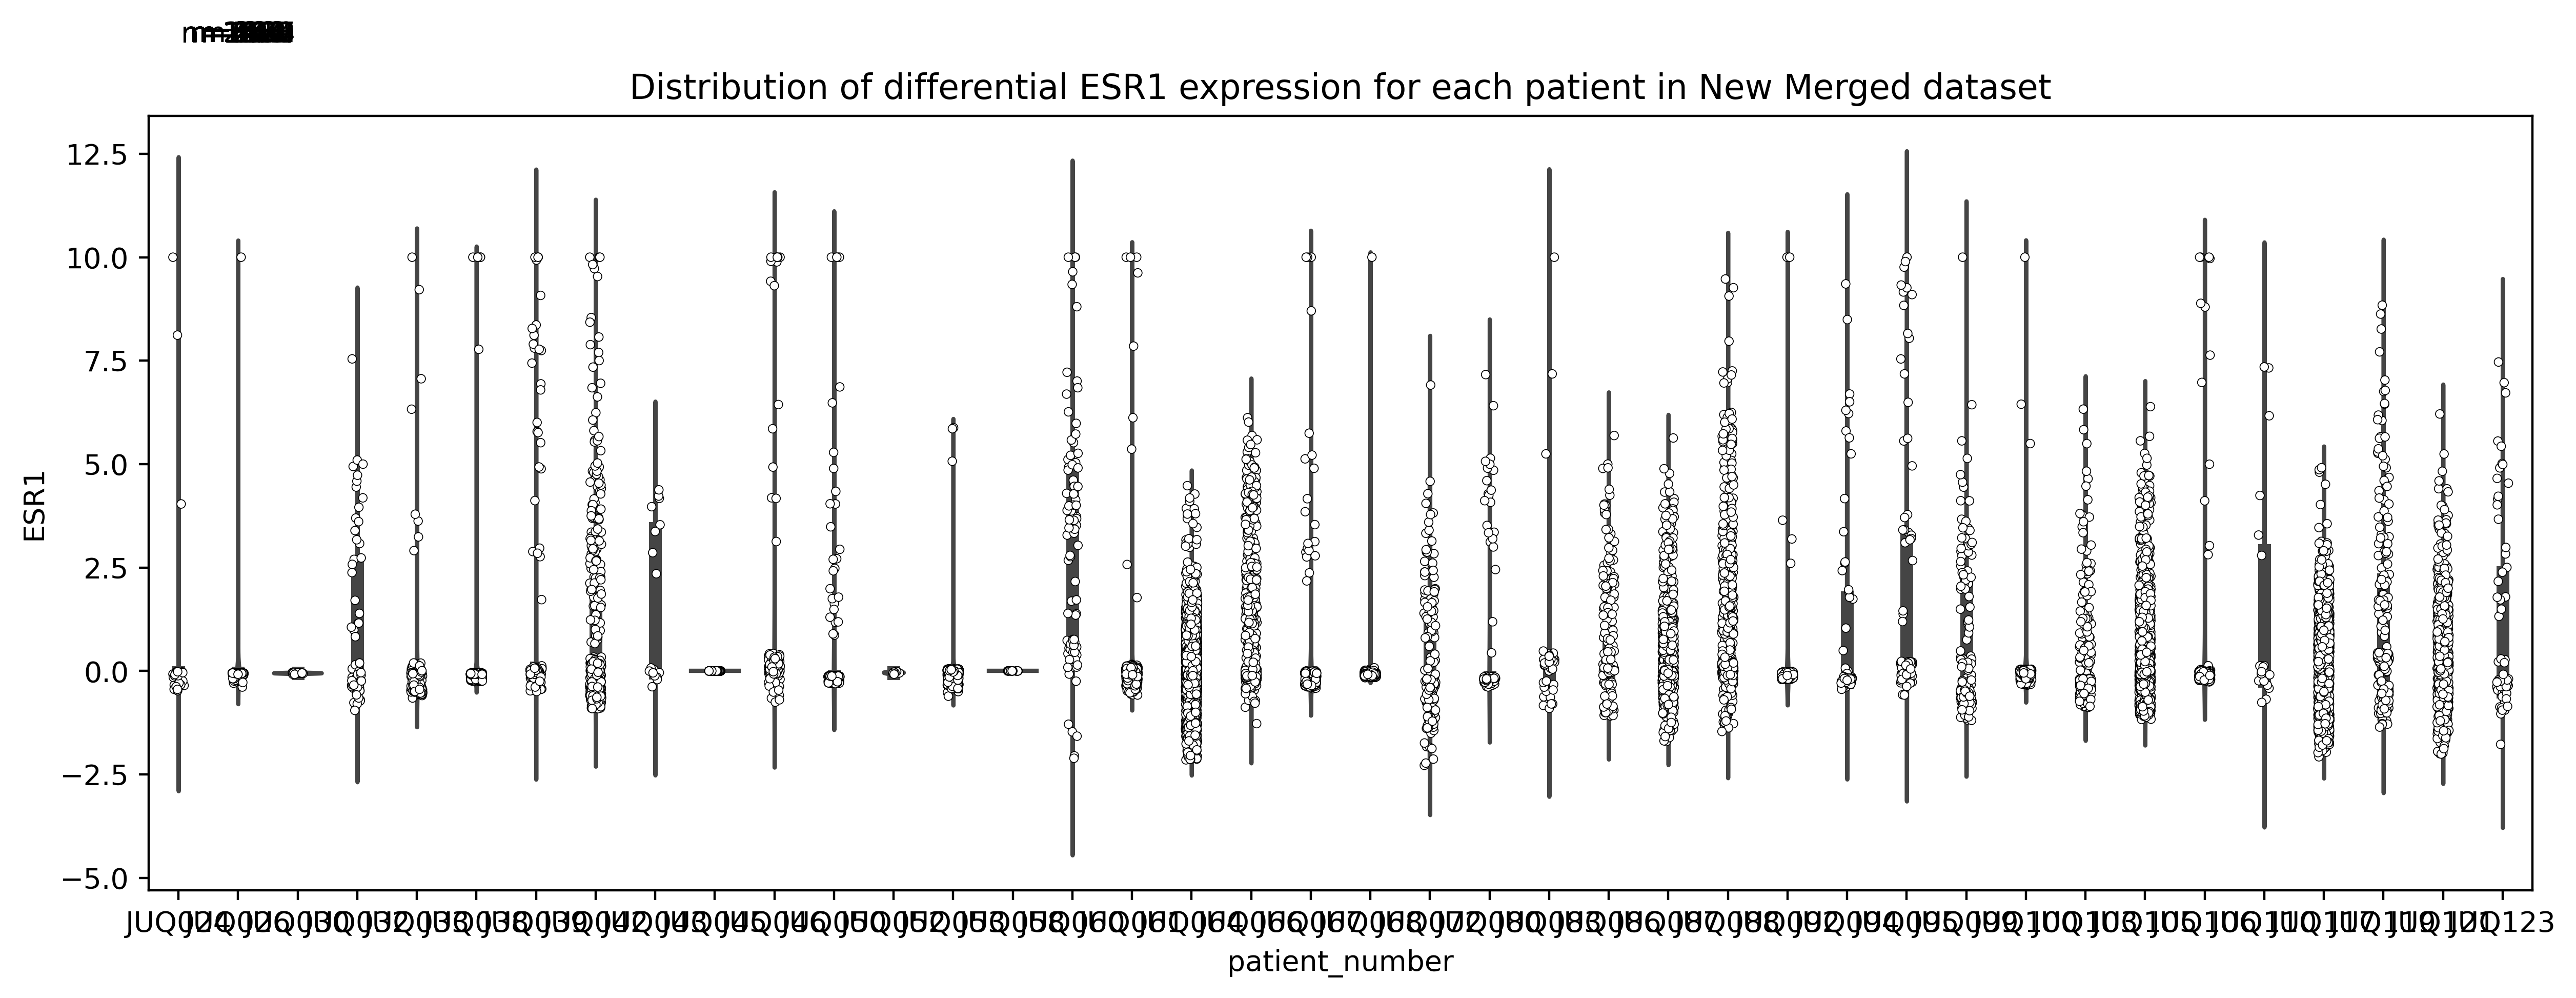

In [150]:
fig, ax = plt.subplots(1,1, dpi=400, figsize=(15,5))
ax = sns.violinplot(x="patient_number", y="ESR1", data=bp_cancer.df)
ax.set_xlabel("Patient number")
ax.set_ylabel("ESR1 Expression")
ax.set_title("Distribution of differential ESR1 expression for each patient in New Merged dataset")
ax = sns.stripplot(data=bp_cancer.df, x='patient_number', y='ESR1',
                   color=("white"), edgecolor="black", linewidth=0.3, ax=ax, s=3)

for pn in bp_cancer.patient_number.unique():
    n = bp_cancer.patient_number.value_counts()[pn]
    x = 1
#    if x > 11:
#        x -= 1
    plt.text(x, 15.2, f"n={n}",horizontalalignment='center')
    x+=1

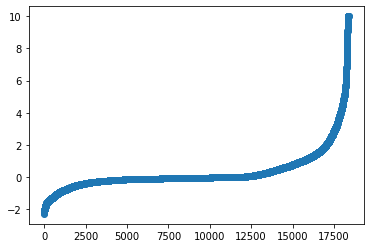

In [146]:
plt.scatter(range(bp_cancer.df['ESR1'].shape[0]), (bp_cancer.df['ESR1'][bp_cancer.df['ESR1'].argsort()]))

(array([7.1000e+01, 4.1700e+02, 7.6900e+02, 1.8880e+03, 1.0058e+04,
        1.6780e+03, 1.1710e+03, 7.1900e+02, 4.1800e+02, 2.6000e+02,
        2.1900e+02, 1.5000e+02, 1.3900e+02, 1.0600e+02, 8.7000e+01,
        5.3000e+01, 3.3000e+01, 2.1000e+01, 2.2000e+01, 1.4000e+01,
        1.3000e+01, 8.0000e+00, 1.0000e+01, 1.1000e+01, 4.9000e+01]),
 array([-2.28181248, -1.78181248, -1.28181248, -0.78181248, -0.28181248,
         0.21818752,  0.71818752,  1.21818752,  1.71818752,  2.21818752,
         2.71818752,  3.21818752,  3.71818752,  4.21818752,  4.71818752,
         5.21818752,  5.71818752,  6.21818752,  6.71818752,  7.21818752,
         7.71818752,  8.21818752,  8.71818752,  9.21818752,  9.71818752,
        10.21818752]),
 <BarContainer object of 25 artists>)

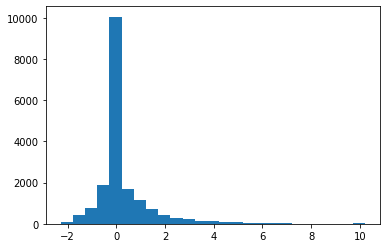

In [148]:
plt.hist(bp_cancer.df['ESR1'],bins=np.arange(min(bp_cancer.df['ESR1']), max(bp_cancer.df['ESR1']) + 0.5, 0.5))

In [112]:
bp_cancer.target = 'ESR1'

In [127]:
X_train, X_test, y_train, y_test = bp_cancer.train_test_split(stratify="target", random_state=10)

In [152]:
X_train.shape

(14707, 40510)

In [138]:
num_round = 500

param = {
    "eta": 0.05,
    "max_depth": 10,
    "tree_method": "gpu_hist",
    'gpu_id': 0
}

# GPU accelerated training
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.to_list())
%time model = xgb.train(param, dtrain,num_round)

CPU times: user 10min 10s, sys: 1.98 s, total: 10min 12s
Wall time: 10min 7s


In [139]:
%%time
# Compute shap values using GPU with xgboost
# model.set_param({"predictor":"cpu_predictor"})
model.set_param({"predictor": "gpu_predictor"})
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_test.columns.to_list())
y_pred = model.predict(dtest, pred_contribs=False)

CPU times: user 20.7 s, sys: 692 ms, total: 21.4 s
Wall time: 1.11 s


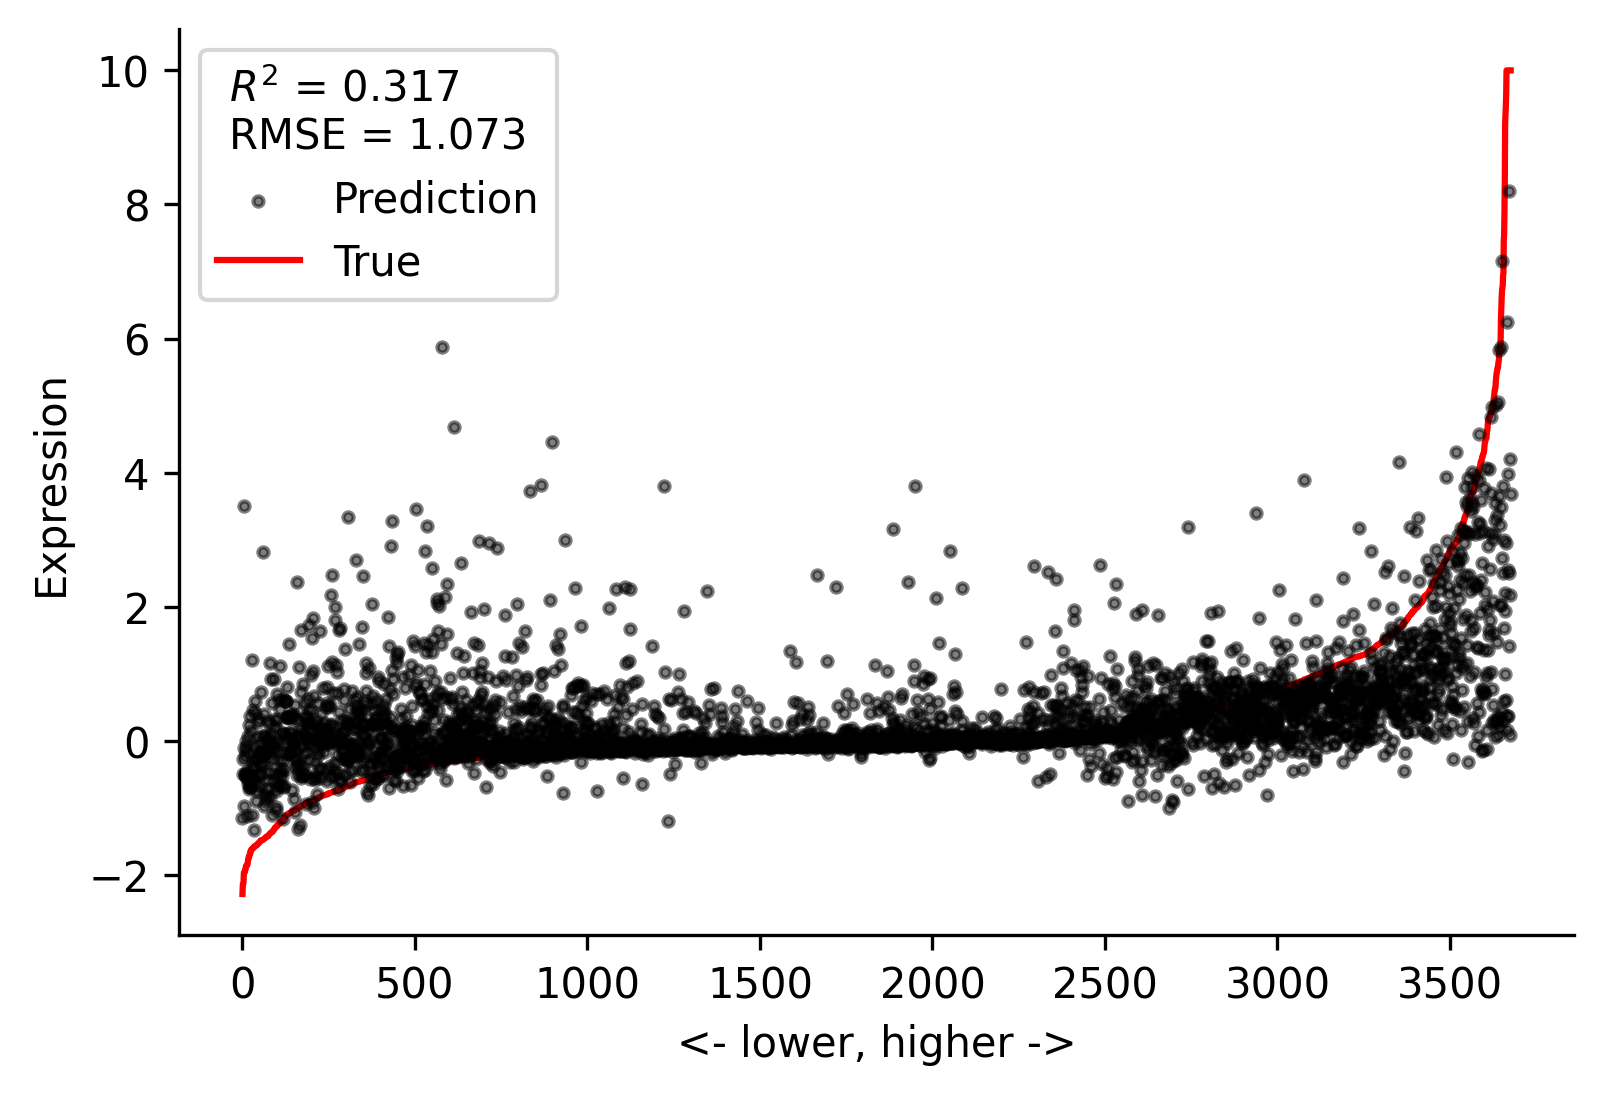

In [145]:
fig, ax = plt.subplots(dpi=300)
plot.plot_prediction(y_test,
                  y_pred,
                  cmap="nipy_spectral",
                  fig=fig,
                  ax=ax
#                  c=bp_cancer.split["patient_number_test"]
                    )
plt.show()

CPU times: user 19.9 s, sys: 393 ms, total: 20.3 s
Wall time: 1.91 s


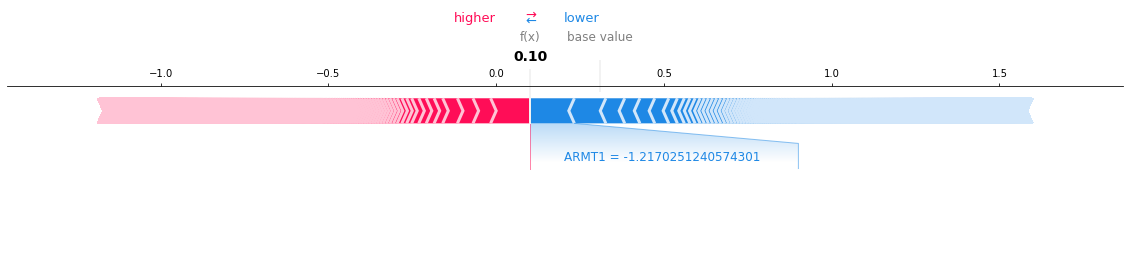

In [166]:
# Use the shap package
import shap


# shap will call the GPU accelerated version as long as the predictor parameter is set to "gpu_predictor"
model.set_param({"predictor": "gpu_predictor"})
explainer = shap.TreeExplainer(model)
%time shap_values = explainer.shap_values(X_test)

# visualize the first prediction's explanation
shap.force_plot(
    explainer.expected_value,
    shap_values[0, :],
    X_test.iloc[0,:],
    feature_names=X_test.columns.to_list(),
    matplotlib=True
)

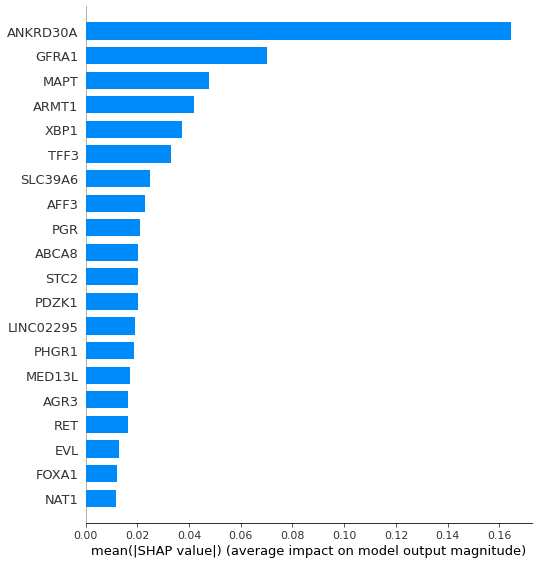

In [167]:
# Show a summary of feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=X_test.columns.to_list())